In [1]:
### Importing packages
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### This takes care of the behind the scenes stuff for creating graphs
def draw_graph(G, size=(10,6), title=None):
    fig, ax = plt.subplots(1, 1, figsize=size);
    nx.draw_networkx(G, ax=ax)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title:
        plt.title(title)
    plt.show()

In [3]:
### Returns the indices of all neighbors of the vertex indexed by 'val' that have an index greater than 'val'
def assoc_vals(val, pairs):
    vals = []
    for pair in pairs:
        if sorted(pair)[0] == val:
            vals.append(sorted(pair)[1])
    return vals

In [4]:
### Generates the trajectories with the provided specifications
def gen_noisy_traj(num_vars, pairs, traj_len):
    
    trajs = [[] for i in range(num_vars)]
    
    for i in range(num_vars):
        
        if len(trajs[i]):
            traj = trajs[i]
        else:
            traj = np.random.normal(0, 1, traj_len)
            trajs[i] = traj
        
        for val in assoc_vals(i, pairs):
            if not len(trajs[val]):
                trajs[val] = traj + np.random.normal(0, 1.0, traj_len)
    
    return trajs

In [5]:
### Computes the mutual information between two trajectories
def mutual_information(x1, x2, bins=50):
    
    b1, _ = np.histogram(x1, bins=bins)
    b1 = b1 / np.sum(b1)
    b2, _ = np.histogram(x2, bins=bins)
    b2 = b2 / np.sum(b2)
    b12, _, _ = np.histogram2d(x1, x2, bins=bins)
    b12 = b12 / np.sum(b12)
    
    mi = 0.0
    for i1 in range(len(b1)):
        for i2 in range(len(b2)):
            if b12[i1][i2] == 0:
                continue;
            mi += b12[i1][i2] * np.log(b12[i1][i2] / (b1[i1] * b2[i2]))            
    return mi

/home/amress/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


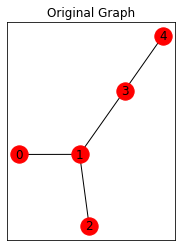

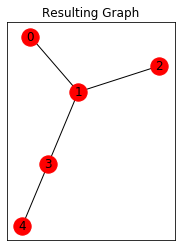

In [6]:
### Testing "noisy" trajectories

# Generating trajectory
num_vars = 5
pairs = [(0,1), (1,2), (1,3), (3,4)]
traj_len = int(1e4)
trajs = gen_noisy_traj(num_vars, pairs, traj_len)

# Making original graph drawing
G1 = nx.Graph()
for edge in pairs:
    G1.add_edge(edge[0], edge[1])
draw_graph(G1, (3,4), title="Original Graph")

# Adding weights between edges
for i in range(num_vars):
    for j in range(i+1, num_vars):
        G1.add_edge(i, j, weight=mutual_information(trajs[i], trajs[j]))

# Making output graph
G2 = nx.Graph()
max_tree = nx.algorithms.tree.mst.maximum_spanning_edges(G1)
for edge in pairs:
    G2.add_edge(edge[0], edge[1])
draw_graph(G2, (3,4), title="Resulting Graph")

In [7]:
### Random seed generation
#     a_list:  values of a in the ax^2 form
def random_seed(a_list):
    sigs = np.sqrt(1.0 / (2.0 * np.array(a_list)))
    return np.random.normal(0.0, sigs)

In [8]:
### Update function to generate new vectors
#     prev_list:    previous values of variables
#     factor:       how much we shift variables by
#     a_list:       values of a in ax^2 form
def update(prev_list, factor, a_list):
    assert (len(prev_list) == len(a_list)),"prev_list and a_list must be of the same length"
    sigs = np.sqrt(1.0 / (2.0 * np.array(a_list)))
    diffs = factor * np.random.normal(0.0, sigs)
    return np.array(prev_list) + diffs

In [47]:
### Writing probability function for generic coupled system
#     x_list:   value of variables (as a list of two variables)
#     a_list:   values of a in ax^2 form
#     b_list:   values of b
def make_potential(x_list, a_list, b_list, pairs):
    assert(len(x_list) == len(a_list)),"x_list and a_list must be of the same length"
    assert(len(b_list) == len(pairs)),"a_list and b_list lengths aren't compatible"
    var_diffs = np.array(a_list) * (np.array(x_list) ** 2)
    inter_dists = [(x_list[i] - x_list[j]) ** 2 for (i,j) in pairs]
    if not len(inter_dists):
        inter_vars = 0.0
    else:
        inter_vars = np.array(b_list) * np.array(inter_dists)
    
    energy = np.sum(var_diffs) + np.sum(inter_vars)
    probability = np.exp(-1 * energy)
    return probability

In [11]:
### Somewhat generalized Metropolis algorithm
#     seed_generator(a_list): function that generates starting seed for a given vector of a values (ax^2)
#     update(prev_list, factor, a_list): function that takes a point and returns an updated point for consideration
#     prob(x_list, a_list, b_list): computes the probability of a point x_list given a set of values a_list and b_list
#     traj_len: length of trajectory
#     factor: value of factor for use in update function
#     a_list: values of a in ax^2 form
#     b_list: values of b
def mod_metropolis(seed_generator, update, prob, traj_len, factor, a_list, b_list):
    traj = []
    point = seed_generator(a_list)
    traj.append(point)
    while (len(traj) < traj_len):
        new_point = update(point, factor, a_list)
        acceptance_ratio = prob(new_point, a_list, b_list) / prob(point, a_list, b_list)
        u = np.random.uniform()
        if u <= acceptance_ratio:
            point = new_point
            traj.append(point)
        else:
            traj.append(point)
    return traj

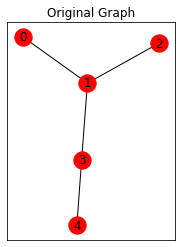

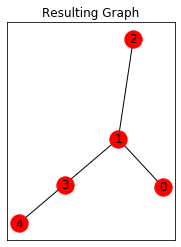

In [50]:
### Testing "coupled" trajectories

pairs = [(0,1), (1,2), (1,3), (3,4)]
traj_len = int(1e5)
a_list = [1.0, 2.0, 3.0, 4.0, 5.0]
b_list = [3.0, 2.0, 1.5, 5.0]

potential = lambda point, a_list, b_list : make_potential(point, a_list, b_list, pairs)
traj = mod_metropolis(random_seed, update, potential, traj_len, 0.1, a_list, b_list)

# Making original graph drawing
G1 = nx.Graph()
for edge in pairs:
    G1.add_edge(edge[0], edge[1])
draw_graph(G1, (3,4), title="Original Graph")

# Adding weights between edges
for i in range(num_vars):
    for j in range(i+1, num_vars):
        G1.add_edge(i, j, weight=mutual_information(trajs[i], trajs[j]))

# Making output graph
G2 = nx.Graph()
max_tree = nx.algorithms.tree.mst.maximum_spanning_edges(G1)
for edge in pairs:
    G2.add_edge(edge[0], edge[1])
draw_graph(G2, (3,4), title="Resulting Graph")